# Churn prediction demo

### senario

Assume that we are working for a modern bank that is about to make its marketing campaigns more data-driven. They observed last autumn that more customers left the bank within the last 12 month than in the years before. Since generally it is much more difficult to get new customers than holding the existing customers, they set high priority to find a solution preventing this churn. For this reason, we start with a usecase tackling this problem. 
So our task is to provide a respective data science solution by implementing the following steps:
- Implement a model to forecast which customers are supposed to leave the bank. How would we prove the quality of the model?
- Which are the most important features to predict churn?
- What are our ideas on mitigating actions to prevent the predicted churn? 
- Which could be good next steps to improve the model and further reduce customer churn?

Please use the `pyproject.toml` to create a suitable poetry environemnt for this project.
And please read every comment for reasoning.

In [45]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shap 
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = 'customer_data.json'
with open(file) as data:
    customer_data = json.load(data)

In [3]:
customer_data = pd.DataFrame.from_dict(customer_data, orient='index')

In [4]:
customer_data.head()

,id,name,credit_rating,country,gender,age,tenure,balance,number_products,credit_card,is_active,estimated_salary,exited,longitude,latitude
1,15634602,Hargrave,619,France,Female,110,2,0.00,1,1,1,101348.88,1,103.90,13.96
2,15647311,Hill,608,Spain,Female,38,1,83807.86,1,0,1,112542.58,0,94.02,27.62
3,15619304,Onio,502,France,Female,54,8,159660.80,3,1,0,113931.57,1,-117.43,-1.20
4,15701354,Boni,699,France,Female,0,1,0.00,2,0,0,93826.63,0,-81.99,55.05
5,15737888,Mitchell,850,Spain,Female,54,2,125510.82,1,1,1,79084.10,0,66.56,-13.90


In [5]:
#### Checking for duplicates.
#### No duplicates founds, so I'm commenting this out.

# customer_data[customer_data['id'].duplicated()]

In [6]:
#### Checking for empty cells.
#### No empty cells founds, so I'm commenting this out.

# customer_data = customer_data.replace(' ', np.nan)
# customer_data[customer_data.isna().any(axis=1)]

In [7]:
#### Dropping the index because sometimes it can cause issues.

customer_data = customer_data.reset_index(drop=True)

### EDA

Text(0, 0.5, 'count')

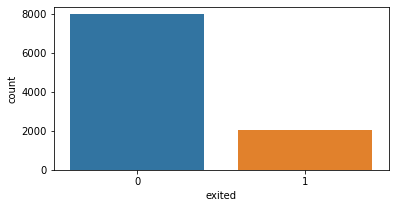

In [8]:
#### Graph to display the unbalance nature of the target feature.

plt.figure(figsize=(6,3))
to_plot = customer_data['exited'].value_counts()
sns.barplot(x=to_plot.index, y=to_plot.values)
plt.xlabel("exited")
plt.ylabel("count")

#### First of all I was curious to see how the geolocation coordinates will be laid out in a map. So following is the code to do that.

In [9]:
import geopandas as gpd
from shapely.geometry import Point

In [10]:
customer_data['geolocation'] = customer_data.apply(lambda row: Point(np.asarray([row['longitude'], row['latitude']])) ,axis=1)


In [11]:
geo_df = gpd.GeoDataFrame(customer_data, crs="EPSG:4326", geometry=list(customer_data['geolocation']))

<AxesSubplot:>

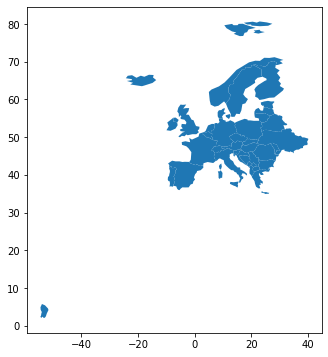

In [12]:
#### Map of europe (or exactly the three countries) with cordinates.

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# europe=world[world['name'].isin(list(customer_data['country'].unique()))]
europe=world[(world.continent == "Europe") & (world.name!="Russia")]
europe.plot(figsize=(6,6))

But unfortunately I found out that it seems geolocations are uniformly evenly distributed within a vast area.
In that case I will be not considering these two geolocation columns in this analysis and also modeling.

<AxesSubplot:>

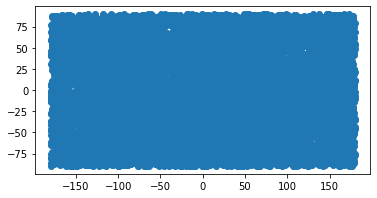

In [13]:
geo_df.plot(figsize=(6,6))

In [14]:
customer_data.drop(columns=['geolocation', 'longitude', 'latitude'], inplace=True)

#### Before do feather analysis I wanted to tryout recent auto EDA libraries for tabular data like pandas_profiling and sweetviz.

In [15]:
#### I'll be using these kind of column list when I want to use specific set of columns for any further analysis or modeling.
# to_analyze = [
#  'credit_rating',
#  'country',
#  'gender',
#  'age',
#  'tenure',
#  'balance',
#  'number_products',
#  'credit_card',
#  'is_active',
#  'estimated_salary',
#  'exited']

#### Please open this saved html from the folder. Which contains lots of graphs and analysis regarding each column and there relationships.

In [16]:
# no need to run this. Please refer to already saved customer_data_pandas_profiling.html in the folder.

# from pandas_profiling import ProfileReport
# profile = ProfileReport(customer_data[to_analyze], title="Profiling Report", explorative=True)
# profile.to_file("customer_data_pandas_profiling.html")

In [17]:
#### Becuse there are lots of 0 balances I wanted to checkout the relationship to churn with and without replacing 
#### these zero's with NaN. Therefor I replaced zero's with NaN.

customer_data['balance_replaced'] = customer_data['balance'].replace(0, np.nan)

#### Please open this saved html from the folder. Which contains lots of graphs and analysis regarding each column and there relationships.

In [18]:
# no need to run this. Please refer to already saved customer_data_sweetviz.html in the folder.

# import sweetviz
# report = sweetviz.analyze(customer_data[to_analyze], target_feat ='exited')
# report.show_html("customer_data_sweetviz.html")

#### According to sweetviz, in the following screenshot you can see the main contributers to churn with regard to correlations.
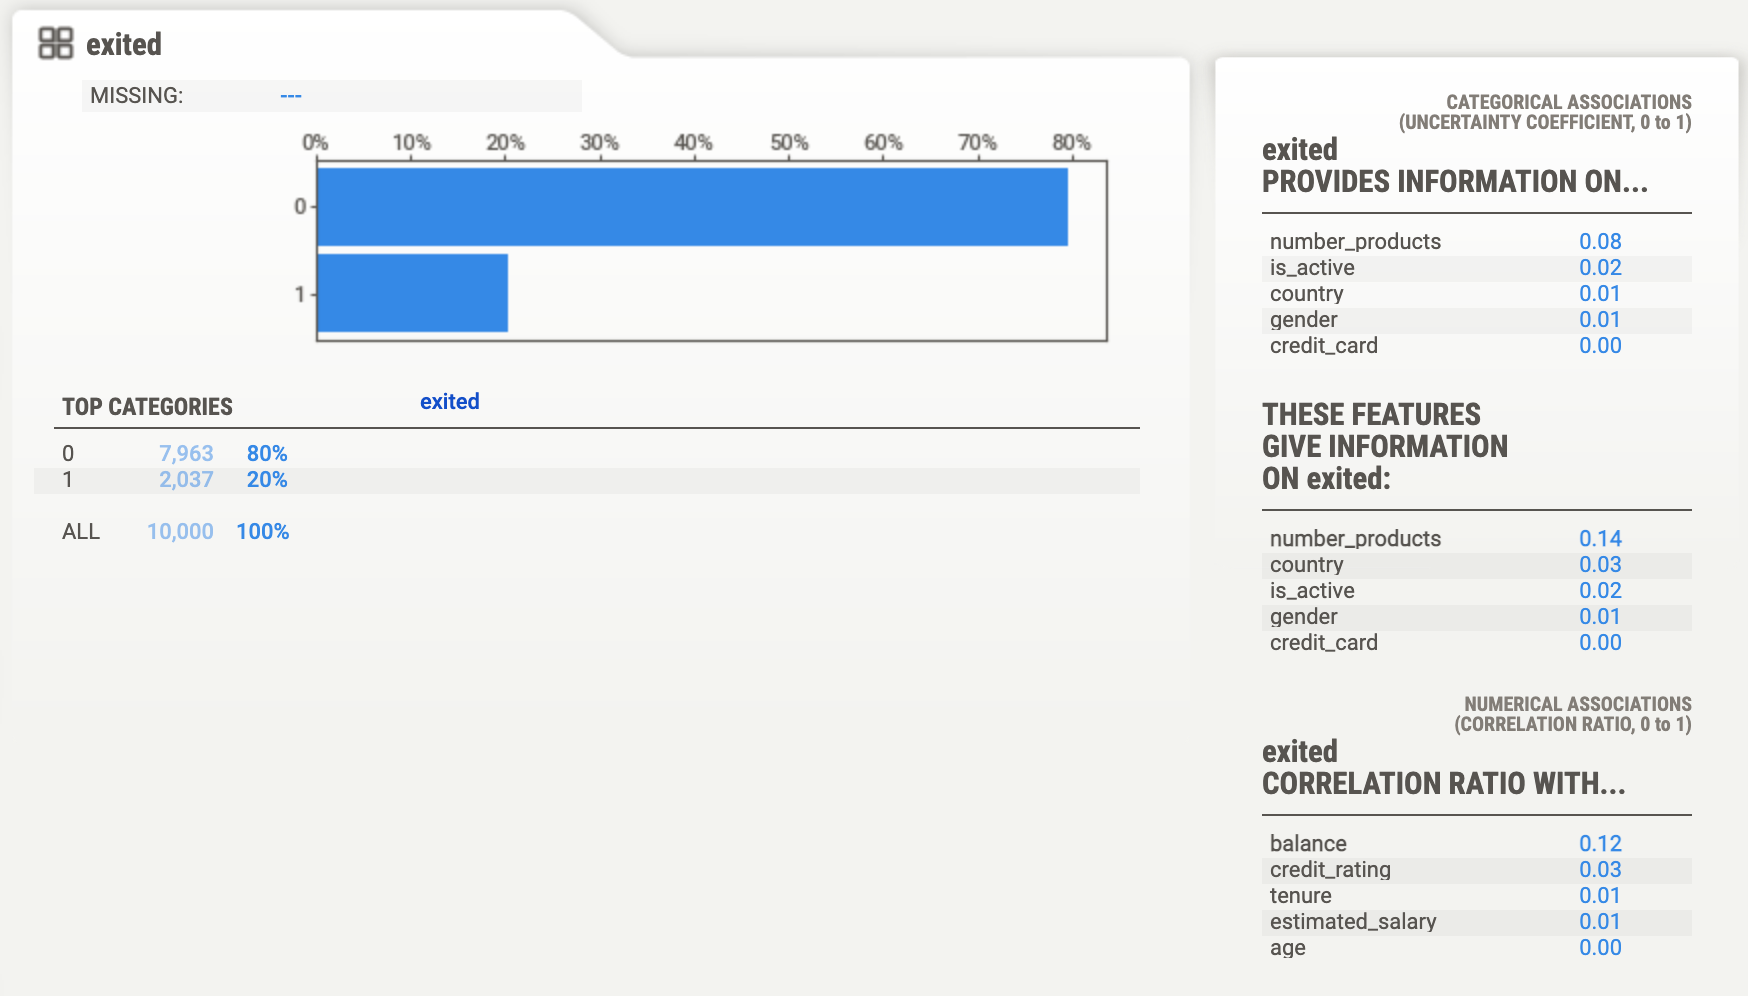

Also I can clearly see age has very unusual numbers like 0 and 149. Which is clearly not possible. But I did not removed the feature because according to more analysis you can see below it gave some kind of information about churn.

In [19]:
#### Encoding categorical features and assigning them to new columns.

le_country = LabelEncoder()
customer_data['country'] = le_country.fit_transform(customer_data['country'])
le_gender = LabelEncoder()
customer_data['gender'] = le_gender.fit_transform(customer_data['gender'])

Graphs to display the relationship to churn with respect to each categorical features.
I'm considering tenure as a categorical feature because it only has 10 discrete levels in this data set.
A good feature is when we can distinguish between churn and non-churn customers, especially when the ratio is different.
We can see that kind of differences in number_of_products, country and slightly in is_active.

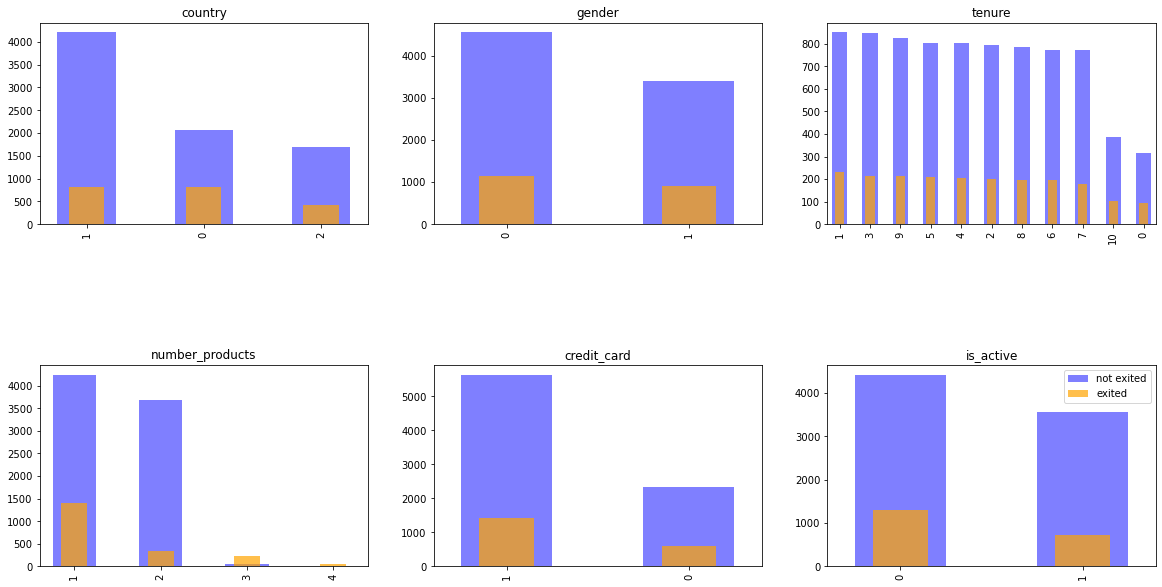

In [20]:
categorical_features = [ 'country', 'gender', 'tenure', 'number_products', 'credit_card', 'is_active']
ROWS, COLS = 2, 3
fig, ax = plt.subplots(ROWS, COLS, figsize=(20, 10) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1: row += 1
    col = i % COLS
    customer_data[customer_data['exited']==0][categorical_feature].value_counts().plot(kind='bar', width=.5, ax=ax[row, col], color='blue', alpha=0.5).set_title(categorical_feature)
    customer_data[customer_data['exited']==1][categorical_feature].value_counts().plot(kind='bar', width=.3, ax=ax[row, col], color='orange', alpha=0.7).set_title(categorical_feature)
    plt.legend(['not exited', 'exited'])
    fig.subplots_adjust(hspace=0.7)

In [21]:
#### These pair plots to analyze the possibility of separating continues features in to groups.

# sns.pairplot(customer_data[['age', 'credit_rating', 'balance', 'estimated_salary', 'exited']],
#              hue='exited',
#              plot_kws=dict(alpha=.3, edgecolor='none'),
#              height=2,
#              aspect=1.1)

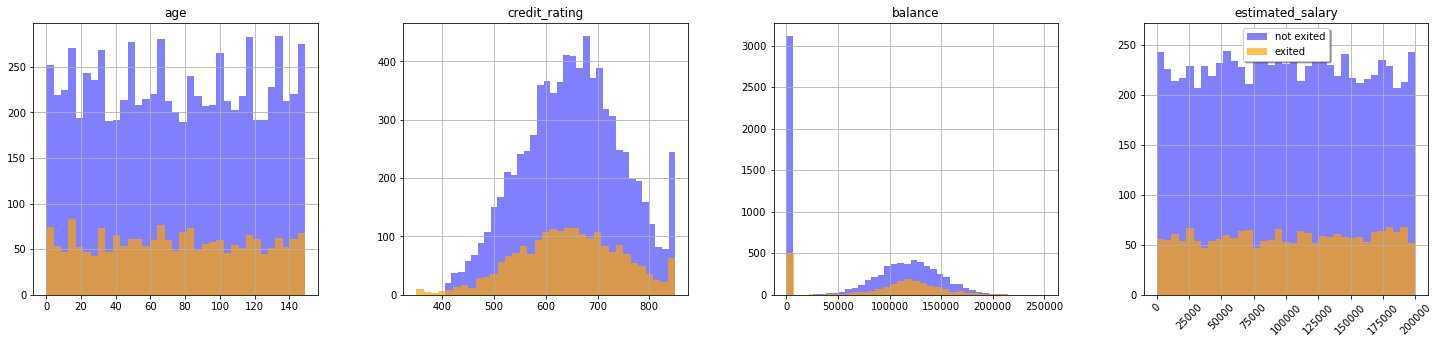

In [22]:
#### Also these bar plots to analyze the possibility of separating continues features in to groups.

num_cols = ['age', 'credit_rating', 'balance', 'estimated_salary']
fig, ax = plt.subplots(1, 4, figsize=(25, 5))
customer_data[customer_data['exited']==0][num_cols].hist(bins=35, color="blue", alpha=0.5, ax=ax)
customer_data[customer_data['exited']==1][num_cols].hist(bins=35, color="orange", alpha=0.7, ax=ax)
plt.xticks(rotation=45)
plt.legend(['not exited', 'exited'], shadow=True, loc=9)

#### But finally decided to use a more systematic way to grouping the continues features (using quartiles) instead of manually deciding the group boundaries. Actually turned out to be better than manually selected groups.

In [23]:
##### Create new colomns and updating it with quartile groups.

customer_data['age_bins'] =  pd.qcut(customer_data['age'], q=3, labels= ['low', 'medium', 'high'])
customer_data['credit_rating_bins'] =  pd.qcut(customer_data['credit_rating'], q=3, labels= ['low', 'medium', 'high'])
customer_data['balance_bins'] =  pd.qcut(customer_data['balance'], q=3, labels= [ 'medium', 'high'], duplicates='drop')
customer_data['estimated_salary_bins'] =  pd.qcut(customer_data['estimated_salary'], q=3, labels= ['low', 'medium', 'high'])

Then same as the previous categorical features, following graphs to display the relationship to churn with artificially created categorical features using continues/nominal features.
We can see a ratio differences in balance, slightly in credit_rating and estimated salary.

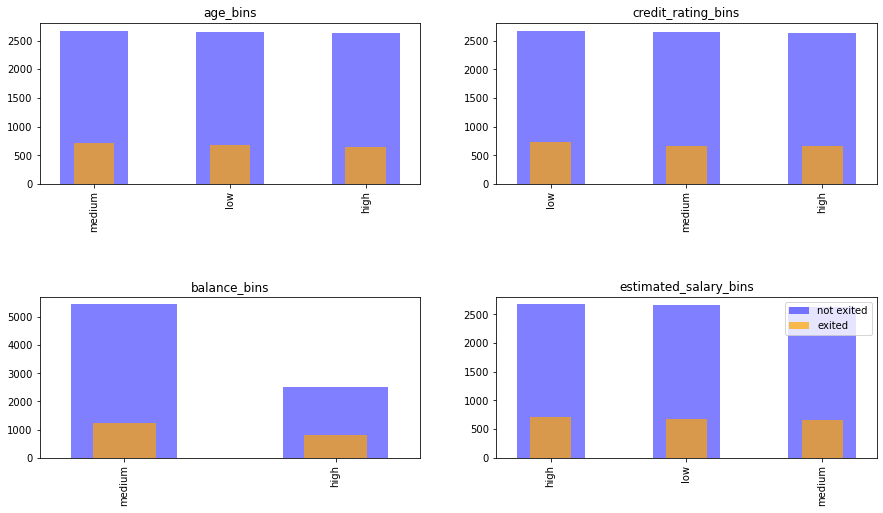

In [24]:
numerical_features = [ 'age_bins', 'credit_rating_bins', 'balance_bins', 'estimated_salary_bins']
ROWS, COLS = 2, 2
fig, ax = plt.subplots(ROWS, COLS, figsize=(15, 8) )
row, col = 0, 0
for i, numerical_feature in enumerate(numerical_features):
    if col == COLS - 1: row += 1
    col = i % COLS
    customer_data[customer_data['exited']==0][numerical_feature].value_counts().plot(kind='bar', width=.5, ax=ax[row, col], color='blue', alpha=0.5).set_title(numerical_feature)
    customer_data[customer_data['exited']==1][numerical_feature].value_counts().plot(kind='bar', width=.3, ax=ax[row, col], color='orange', alpha=0.7).set_title(numerical_feature)
    plt.legend(['not exited', 'exited'])
    fig.subplots_adjust(hspace=0.7)

In [25]:
#### Encoding created bin colomns features.

le_age_group = LabelEncoder()
customer_data['age_bins'] = le_age_group.fit_transform(customer_data['age_bins'])
le_credit_rating_group = LabelEncoder()
customer_data['credit_rating_bins'] = le_credit_rating_group.fit_transform(customer_data['credit_rating_bins'])
le_balance_group = LabelEncoder()
customer_data['balance_bins'] = le_balance_group.fit_transform(customer_data['balance_bins'])
le_estimated_salary_group = LabelEncoder()
customer_data['estimated_salary_bins'] = le_estimated_salary_group.fit_transform(customer_data['estimated_salary_bins'])

#### All features that will be used for modeling should be normalized so that each feature contributes approximately proportionately to the final distance, so we do feature scaling.

In [26]:
#### After some test runs I decided to keep age as it is without scaling to achieve max performance.
#### Scaling Numerical columns 
sc = MinMaxScaler()
# customer_data['age_scaled'] = sc.fit_transform(customer_data[['age']])
customer_data['credit_rating_scaled'] = sc.fit_transform(customer_data[['credit_rating']])
customer_data['balance_scaled'] = sc.fit_transform(customer_data[['balance']])
customer_data['estimated_salary_scaled'] = sc.fit_transform(customer_data[['estimated_salary']])

### Outliers detection
#### I wanted to see if there are outliers and what, how good models will perform after removing them.

In [27]:
to_analyze = [
 'credit_rating',
 'country',
 'gender',
 'age',
 'tenure',
 'balance_scaled',
 'number_products',
 'credit_rating_scaled',
 'is_active',
 'estimated_salary_scaled']

In [28]:
lr = LinearRegression()
y = customer_data['exited'].values
x = customer_data[to_analyze].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)
print(X_train.shape, y_train.shape)

(6700, 10) (6700,)


In [29]:
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
metrics.mean_absolute_error(y_test, pred)

0.30892324245409053

In [30]:
lof = LocalOutlierFactor()
pred = lof.fit_predict(X_train)

In [31]:
mask = pred != -1

In [32]:
X_train, y_train = X_train[mask, :], y_train[mask]
print(X_train.shape, y_train.shape)

(6690, 10) (6690,)


In [33]:
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
metrics.mean_absolute_error(y_test, pred)

0.308607650152797

#### But as you can see above there was no performance improvements to the model after removing outliers so I decided to not to remove them.

### Clustering
#### Also I was curios to see how the unsupervised algorithms will turnout clustering the customers. So I tried out KMeans clustering.

In [54]:
to_analyze = [
 'credit_rating',
 'country',
 'gender',
 'age',
 'tenure',
 'balance_scaled',
 'number_products',
 'credit_rating_scaled',
 'is_active',
 'estimated_salary_scaled']

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [80]:
sc = StandardScaler()
X = sc.fit_transform(customer_data[to_analyze].values)
Y = customer_data[['exited']].values.ravel()

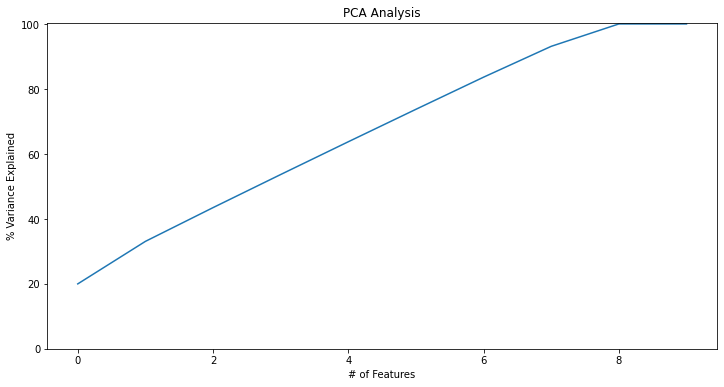

In [57]:
#n_components=7 because we have 7 features in the dataset
pca = PCA(n_components=10)
pca.fit(X)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.figure(figsize=(12,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(0,100.5)
plt.plot(var)

#### First 5 principal components explain roughly 75% of the variance. Therefor we can apply PCA again and reduce our dataset to 5 principal components.

In [58]:
pca = PCA(n_components=5)
pca_scale = pca.fit_transform(X)
pca_df_scale = pd.DataFrame(pca_scale, columns=['pc1','pc2','pc3','pc4','pc5'])
print(pca.explained_variance_ratio_)

[0.20020784 0.13141528 0.10378887 0.10165334 0.10053035]


In [59]:
# Create the K means model for different values of K
def try_different_clusters(K, data):
       
    cluster_values = list(range(1, K+1))
    inertias=[]
    
    for c in cluster_values:
        model = KMeans(n_clusters = c,init='k-means++',max_iter=400,random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)
    
    return inertias

In [60]:
outputs = try_different_clusters(12, pca_df_scale)

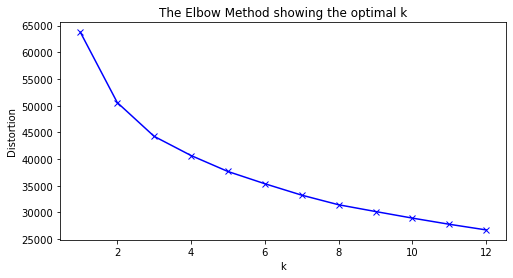

In [61]:
plt.figure(figsize=(8,4))
plt.plot(list(range(1, 13)), outputs, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [62]:
kmean_model = KMeans(n_clusters =2,init='k-means++',max_iter=400,random_state=42)
kmean_model.fit(pca_df_scale)

KMeans(max_iter=400, n_clusters=2, random_state=42)

In [63]:
labels_pca_scale = kmean_model.labels_
clusters_pca_scale = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale})], axis=1)

In [83]:
clusters_pca_scale = pd.concat([clusters_pca_scale, pd.DataFrame({'Y':Y})], axis=1)

In [84]:
clusters_pca_scale

,pc1,pc2,pc3,pc4,pc5,pca_clusters,tsne-2d-one,tsne-2d-two,Y
0,0.439180,0.428837,-0.992145,1.673268,-0.361768,0,3.467090,6.650340,1
1,0.594308,-0.885090,-0.843698,1.000805,-0.029798,0,-3.575557,-17.845663,0
2,2.176439,1.051524,1.737039,0.338402,-0.069251,0,-25.680702,11.149843,1
3,-0.643369,1.529336,0.624755,1.598587,-1.474975,1,10.642270,33.370823,0
4,-2.953567,-1.370454,-0.863226,0.855704,0.273156,1,28.869619,-7.265184,0
...,...,...,...,...,...,...,...,...,...
9995,-1.735553,1.438790,0.211504,-0.144146,0.391895,1,13.046126,24.668543,0
9996,1.957896,-0.215974,-0.069499,-1.533129,-0.692371,0,-14.284566,0.018065,0
9997,-0.851154,0.500803,-0.183644,0.257846,-1.290795,1,8.631910,-1.383517,1
9998,-1.750487,0.380705,0.044902,-0.215623,0.320230,1,25.473886,8.159144,1


But as you can see above, after trying out elbow method to find out optimal clusters, it seemed that 2 clusters is the optimal. But It is hard to display these clusters in which is in 5 dimensions and need to reduce. To achieve that I will be using t-SNE.

In [85]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(clusters_pca_scale[['pc1','pc2','pc3','pc4','pc5']])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 0.546s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.499600
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.947815
[t-SNE] KL divergence after 500 iterations: 2.145950


In [86]:
clusters_pca_scale['tsne-2d-one'] = tsne_results[:,0]
clusters_pca_scale['tsne-2d-two'] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

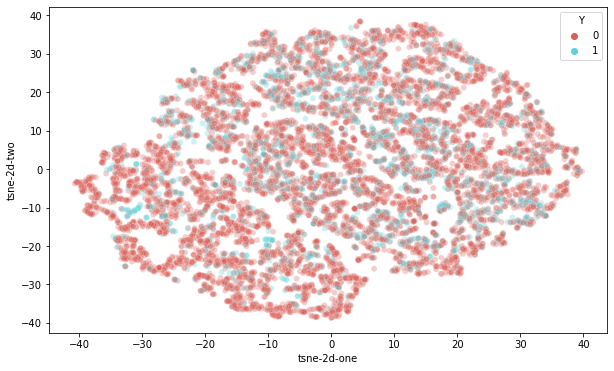

In [88]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Y",
    palette=sns.color_palette("hls", 2),
    data=clusters_pca_scale,
    legend="full",
    alpha=0.3
)

As you can see it didn't turn out so well.

### Imputations
#### Also I wanted to try out how the models will perform with and without imputing the balance zero cells. So I did impute those and after comparing I find out its also unnecessary in this dataset.

In [45]:
to_analyze = [
 'credit_rating',
 'country',
 'gender',
 'age',
 'tenure',
 'balance_replaced',
 'number_products',
 'credit_card',
 'is_active',
 'estimated_salary'
]

In [46]:
lr = LinearRegression()
test_df = customer_data[to_analyze][customer_data['balance_replaced'].isnull()==True]
train_df = customer_data[to_analyze][customer_data['balance_replaced'].isnull()==False]
y = train_df['balance_replaced']
train_df = train_df.drop('balance_replaced',axis=1)
lr.fit(train_df,y)

LinearRegression()

In [47]:
test_df = test_df.drop("balance_replaced",axis=1)
pred = lr.predict(test_df)
test_df['balance_replaced']= pred
train_df['balance_replaced'] = y

In [48]:
temp_df = pd.concat([test_df, train_df])
temp_df.sort_index(inplace=True)

In [49]:
customer_data['balance_filled'] = temp_df['balance_replaced']

### Feature importance

#### Plotting correlation against each feature.

In [50]:
to_analyze = [
 'country',
 'gender',
 'tenure',
 'number_products',
 'credit_card',
 'is_active',
 'age',
 'balance_scaled',
 'credit_rating_scaled',
 'estimated_salary_scaled',
 'exited'
]

In [51]:
corr = customer_data[to_analyze].corr()

<AxesSubplot:>

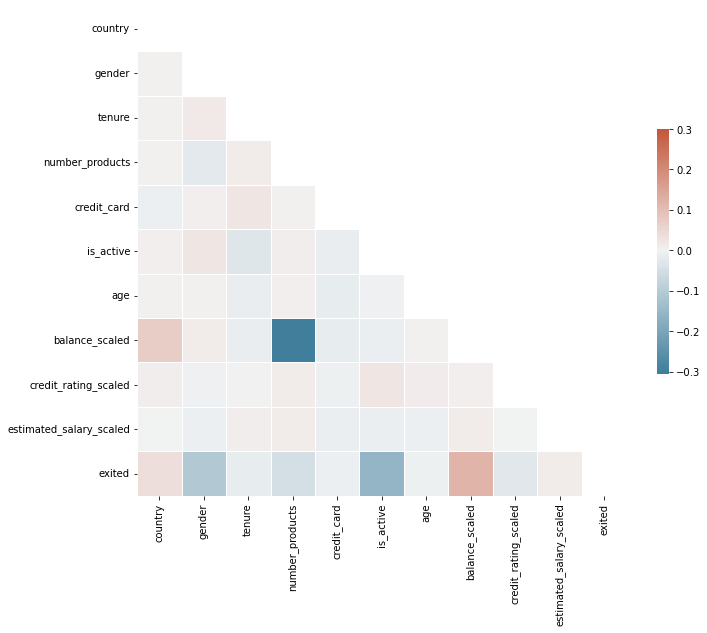

In [52]:
#### Below plot depicts highly correlated features.

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlation measures the linear relationship between two variables. Features with high correlation are more linearly dependent and have almost the same effect on the dependent variable. So, when two features have a high correlation (except for the target), we can drop one of them. In our case, we don't have any suitable candidates to do so.

#### Logistic regression to find out statistically significant features to exited.

In [53]:
to_analyze = [
 'country',
 'gender',
 'tenure',
 'number_products',
 'credit_card',
 'is_active',
 'age',
 'balance_scaled',
 'credit_rating_scaled',
 'estimated_salary_scaled'
]

In [54]:
customer_data_shuffled = customer_data.sample(frac=1)

In [55]:
log_reg = sm.Logit(customer_data_shuffled['exited'], customer_data_shuffled[to_analyze])
res = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.480732
         Iterations 6


In [56]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:                 exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9990
Method:                           MLE   Df Model:                            9
Date:                Thu, 21 Apr 2022   Pseudo R-squ.:                 0.04898
Time:                        11:57:38   Log-Likelihood:                -4807.3
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                6.298e-101
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
country                     0.0792      0.031      2.565      0.010       0.019       0.140
gender                     -0.5903      0.050    -11.742      0.000      -0.689      -0.492


Using the __P>|z|__ column we answer the question which features affect churn. If the absolute p-value is smaller than 0.05, it means that the feature affects Churn in a statistically significant way. In our case all features except for _estimated_salary_.

In [57]:
np.exp(res.params)

country                    1.082430
gender                     0.554157
tenure                     0.972624
number_products            0.820955
credit_card                0.887953
is_active                  0.432933
age                        0.998766
balance_scaled             2.683115
credit_rating_scaled       0.505925
estimated_salary_scaled    0.936728
dtype: float64

Feature importances can be answered by looking at above exponential coefficient values. The exponential coefficient estimates the expected change in churn through a given feature by a change of one unit.
Values more than 1 indicate increased churn. Values less than 1 indicate that churn is happening less.

#### Selecting optimal number of features using RFECV method.
Feature selection to enable the machine learning algorithm to train faster, reduce model complexity, increase interpretability, and improve model accuracy if the right features subset is chosen.

I used DecisionTreeClassifier for this feature selection method because it gave best results later.

In [58]:
# customer_data.head()

In [59]:
to_analyze = [
 'country',
 'gender',
 'tenure',
 'number_products',
 'credit_card',
 'is_active',
 'age', 
 'credit_rating_scaled',
 'balance_scaled',
 'estimated_salary_scaled'
]

In [60]:
x_train, x_test, y_train, y_test = train_test_split(customer_data[to_analyze], customer_data['exited'], random_state=2023, test_size=0.3, stratify=customer_data['exited'])


In [61]:
# Feature selection to improve model building
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
model = DecisionTreeClassifier()
rfecv = RFECV(estimator=model, cv=StratifiedKFold(5, random_state=0, shuffle=True), scoring="accuracy")
rfecv.fit(x_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
      estimator=DecisionTreeClassifier(), scoring='accuracy')

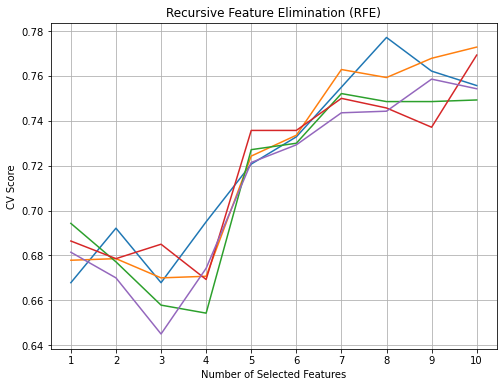

The optimal number of features: 10


In [62]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.grid()
plt.xticks(range(1, x_train.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

So I'll be using all features for model training.

In [63]:
print(rfecv.support_)
print(rfecv.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


### Model selection

In [64]:
#Defining the modelling function
def modeling(x_train, x_test, alg, alg_name, params={}):
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    #Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print(f"-------{alg_name}-------")
        acc_score = metrics.accuracy_score(y_true, y_pred)
        print("accuracy: ",round(acc_score, 3))
        report = metrics.classification_report(y_test, y_pred)
        print(report)

    print_scores(alg, y_test, y_pred)
    return model

# Running logistic regression model
log_model = modeling(x_train, x_test, LogisticRegression, 'Logistic Regression')
svc_model = modeling(x_train, x_test, SVC, 'SVC')
rf_model = modeling(x_train, x_test, RandomForestClassifier, "Random Forest", {'n_estimators':100, 'max_depth':2, 'random_state':0})
dt_model = modeling(x_train, x_test, DecisionTreeClassifier, "Decision Tree")
nb_model = modeling(x_train, x_test, GaussianNB, "Naive Bayes")


-------Logistic Regression-------
accuracy:  0.797
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2389
           1       1.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.90      0.50      0.45      3000
weighted avg       0.84      0.80      0.71      3000

-------SVC-------
accuracy:  0.796
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2389
           1       0.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000

-------Random Forest-------
accuracy:  0.81
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      2389
           1       1.00      0.07      0.13       611

    accuracy                           0.81      300

So according to both accuracy and f1 score for 'exited' we can choose __Decision Tree__ as the best performed classifier. So using that I did the hyperparameter tuning.

In [65]:
## Improve best model by hyperparameter tuning
# define model
model = DecisionTreeClassifier()

# define evaluation
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
from sklearn.utils.fixes import loguniform
space = dict()
space['criterion'] = ['gini', 'entropy']
space['splitter'] = ['best', 'random']
space['max_depth'] = [2, 3, 5, 10, 20]
space['min_samples_leaf'] = [5, 10, 20, 50, 100]

# define search
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(x_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
params = result.best_params_


Best Score: 0.8292380952380953
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'splitter': 'best'}


In [66]:
params

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 50,
 'splitter': 'best'}

In [67]:
dt_model = modeling(x_train, x_test, DecisionTreeClassifier, "Decision Tree", params)

-------Decision Tree-------
accuracy:  0.818
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2389
           1       0.59      0.33      0.43       611

    accuracy                           0.82      3000
   macro avg       0.72      0.64      0.66      3000
weighted avg       0.80      0.82      0.80      3000



In [68]:
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(x_test)

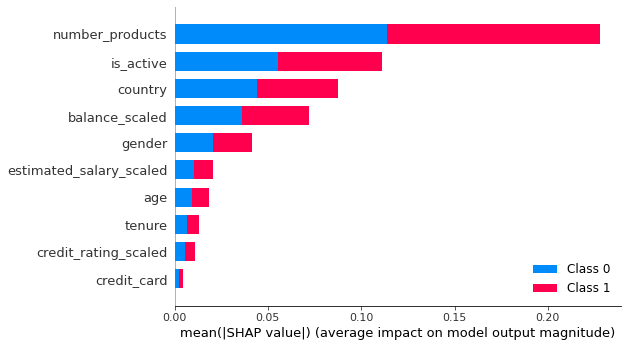

In [69]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

According to the above TreeExplainer plot most important features are:

- number_products
- is_active
- country

#### Trying out a different model
Even though I kind of finished the analysis and modeling, I was curious to to find out how modern deep learning/state of the art models will perform in this data set. Therefor I tried out __pytorch_tabnet__ TabNetClassifier from this [research paper](https://arxiv.org/pdf/1908.07442.pdf).

I found out just using the features wont give any impressive results. Therefor I tried out the unsupervised pre-training function given in the library. 
And also using raw features without scaling also increased the performance of the model.

In [69]:
to_analyze = [
 'country',
 'gender',
 'tenure',
 'number_products',
 'credit_card',
 'is_active',
 'age', 
 'credit_rating',
 'balance',
 'estimated_salary'
]

In [70]:
x_train, x_test, y_train, y_test = train_test_split(customer_data[to_analyze], customer_data['exited'], random_state=2025, test_size=0.4, stratify=customer_data['exited'])


In [71]:
x_test['exited'] = y_test
x_val, x_test, y_val, y_test = train_test_split(x_test[to_analyze], x_test['exited'], random_state=2025, test_size=0.5, stratify=x_test['exited'])


In [72]:
columns_ = x_train.columns
x_train = x_train.values
x_val = x_val.values
x_test = x_test.values

In [73]:
# TabNetPretrainer
unsupervised_model_no_preproc = TabNetPretrainer(
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax"
)

Device used : cpu


In [74]:
unsupervised_model_no_preproc.fit(
    x_train,
    eval_set=[x_val],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.80,
)

epoch 0  | loss: 7.12943 | val_0_unsup_loss: 8.8333  |  0:00:00s
epoch 1  | loss: 6.29791 | val_0_unsup_loss: 6.97418 |  0:00:01s
epoch 2  | loss: 6.19408 | val_0_unsup_loss: 6.5732  |  0:00:02s
epoch 3  | loss: 6.04682 | val_0_unsup_loss: 6.90059 |  0:00:03s
epoch 4  | loss: 5.66158 | val_0_unsup_loss: 5.8486  |  0:00:04s
epoch 5  | loss: 5.18673 | val_0_unsup_loss: 5.43679 |  0:00:05s
epoch 6  | loss: 4.57517 | val_0_unsup_loss: 5.05792 |  0:00:06s
epoch 7  | loss: 3.97321 | val_0_unsup_loss: 4.69571 |  0:00:07s
epoch 8  | loss: 3.35385 | val_0_unsup_loss: 4.41139 |  0:00:07s
epoch 9  | loss: 2.74671 | val_0_unsup_loss: 4.12413 |  0:00:08s
epoch 10 | loss: 2.29903 | val_0_unsup_loss: 4.06325 |  0:00:09s
epoch 11 | loss: 2.04201 | val_0_unsup_loss: 4.24223 |  0:00:10s
epoch 12 | loss: 1.84946 | val_0_unsup_loss: 4.23363 |  0:00:11s
epoch 13 | loss: 1.73149 | val_0_unsup_loss: 4.23644 |  0:00:12s
epoch 14 | loss: 1.63455 | val_0_unsup_loss: 4.16927 |  0:00:13s
epoch 15 | loss: 1.59776 

In [75]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model_no_preproc.predict(x_val)
assert(reconstructed_X.shape==embedded_X.shape)

In [76]:
unsupervised_model_no_preproc.save_model('./custom_data_pretrain')

Successfully saved model at ./custom_data_pretrain.zip


'./custom_data_pretrain.zip'

In [77]:
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./custom_data_pretrain.zip')

Device used : cpu
Device used : cpu


In [78]:
# define the model
model = TabNetClassifier(optimizer_fn=torch.optim.AdamW,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.7},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

# fit the model 
model.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
    
)

Device used : cpu
Loading weights from unsupervised pretraining
epoch 0  | loss: 1.0609  | train_auc: 0.56147 | train_accuracy: 0.41117 | valid_auc: 0.5882  | valid_accuracy: 0.4355  |  0:00:00s
epoch 1  | loss: 0.63929 | train_auc: 0.42538 | train_accuracy: 0.3995  | valid_auc: 0.45265 | valid_accuracy: 0.4165  |  0:00:01s
epoch 2  | loss: 0.61632 | train_auc: 0.62184 | train_accuracy: 0.65567 | valid_auc: 0.62448 | valid_accuracy: 0.6615  |  0:00:02s
epoch 3  | loss: 0.61086 | train_auc: 0.683   | train_accuracy: 0.37617 | valid_auc: 0.6759  | valid_accuracy: 0.3745  |  0:00:03s
epoch 4  | loss: 0.61696 | train_auc: 0.67349 | train_accuracy: 0.42117 | valid_auc: 0.67261 | valid_accuracy: 0.413   |  0:00:03s
epoch 5  | loss: 0.59396 | train_auc: 0.72349 | train_accuracy: 0.4345  | valid_auc: 0.7303  | valid_accuracy: 0.44    |  0:00:04s
epoch 6  | loss: 0.57565 | train_auc: 0.72162 | train_accuracy: 0.786   | valid_auc: 0.74895 | valid_accuracy: 0.801   |  0:00:05s
epoch 7  | loss: 0.

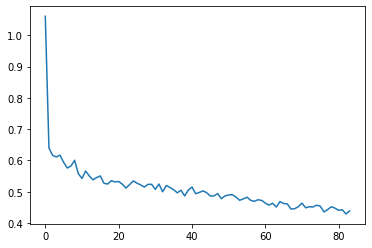

In [79]:
# plot losses
plt.plot(model.history['loss'])

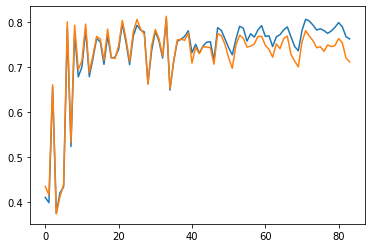

In [80]:
# # plot accuracy
plt.plot(model.history['train_accuracy'])
plt.plot(model.history['valid_accuracy'])

In [81]:
preds = model.predict(x_test)
test_acc = metrics.accuracy_score(preds, y_test)


preds_valid = model.predict(x_val)
valid_acc = metrics.accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.8135
BEST ACCURACY SCORE ON TEST SET : 0.7855


<AxesSubplot:>

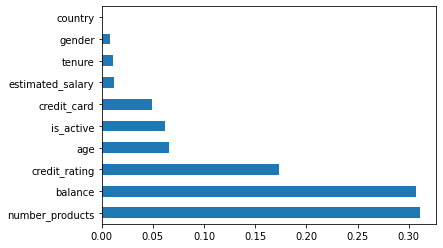

In [82]:
feat_importances = pd.Series(model.feature_importances_, index=columns_)
feat_importances.nlargest(20).plot(kind='barh')

In [83]:
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1593
           1       0.48      0.59      0.53       407

    accuracy                           0.79      2000
   macro avg       0.68      0.71      0.69      2000
weighted avg       0.80      0.79      0.79      2000



So finally as you can see above this model gave the overall best result, when we compare the f1 score for 'exited' true which is churn. But still f1 score of 0.53 is very low.
And according to that model most important features are:
- number_product
- balance
- credit_rating

But according to the best performed DecisionTreeClassifier model three most important features are:
- number_products
- is_active
- country

So _number_products_ is the most strait forward feature to reduce churn.

Here we have prove the quality of the model using an unseen test data set.
So we can say this model is 89% precise about predicting customers who will not leave and 48% precise about predicting customers who will churn.
precision for churn means how many of the clients identified by the model actually left.
recall for churn means how many of the clients who actually leave were detected by the model.

We can improve this model by having a balanced data set for churned and not churned. Yes we can do it here also by doing the under-sampling, but then the amount of data is very low after splitting the data. 
So then we can try oversampling methods. But then again these methods should be experimented with our data set.

Also it is better to have the churn cut off date with the data set. So then we can select data points to use if we want to predict the churn before a specific time. We shouldn’t be using any information after the cut-off date as a feature in the machine learning model, otherwise it will be a leakage.

For example, we want to predict if the customer will churn within the next quarter. So the data gathering procedure should be, iterate through all the existing customers a quarter before and gather data at that time. So the target feature exited should be collected now (or a quarter after the actual gathered data) 1 if they aren't customers any more, 0 if they are still customers.

Also churn prediction can get more accurate if we use time series data and make predictions using them.

According to this given scenario. In order to reduce the predicted churn we can do following.
- Trying to sell more products to the customer.
- Encouraging customers to use the bank more by introducing special offers.
- Finding more customers from specific geographies.

_Author - Hiran Dissanayake_ <br>
_E-mail - hiranhsw@gmail.com_